# results フォルダに格納された結果を可視化するノートブック

以下のpythonスクリプトを実行した後に，実行結果を可視化するノートブック

- src/compute_ss_by_several_psi.py
- src/run_pension_scenarios.py

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib  # noqa: F401
import olg

## 結果を全て読み込む

In [4]:
# 移行過程の結果
transition_results_path = [
  "psi_50to00",
  "psi_50to25",
  "psi_50to50",
  "psi_50to75",
  "psi_50to100"
]
transition_results = {}
for path in transition_results_path:
  with open(f"results/{path}/full.pkl", "rb") as f:
    transition_results[path] = pickle.load(f)

In [7]:
transition_results.keys(), transition_results["psi_50to00"].keys()

(dict_keys(['psi_50to00', 'psi_50to25', 'psi_50to50', 'psi_50to75', 'psi_50to100']),
 dict_keys(['initial_result', 'final_result', 'converged_K_path', 'opt_indexes', 'aprimes', 'value_functions', 'mu_dist_path']))

In [8]:
# いくつかの定常状態の結果
ss_results_path = [
  "ss_psi_00",
  "ss_psi_05",
  "ss_psi_10",
  "ss_psi_15",
  "ss_psi_20",
  "ss_psi_25",
  "ss_psi_30",
  "ss_psi_35",
  "ss_psi_40",
  "ss_psi_45",
  "ss_psi_50",
  "ss_psi_75",
  "ss_psi_100"
]
ss_results = {}
for path in ss_results_path:
  with open(f"results/{path}/steady_state_result.pkl", "rb") as f:
    ss_results[path] = pickle.load(f)

In [14]:
ss_results.keys(), ss_results["ss_psi_00"].__dict__.keys()

(dict_keys(['ss_psi_00', 'ss_psi_05', 'ss_psi_10', 'ss_psi_15', 'ss_psi_20', 'ss_psi_25', 'ss_psi_30', 'ss_psi_35', 'ss_psi_40', 'ss_psi_45', 'ss_psi_50', 'ss_psi_75', 'ss_psi_100']),
 dict_keys(['K', 'r', 'w', 'p', 'tau', 'L', 'value_fun_box', 'policy_fun_box', 'optaprime_index_box', 'mu_dist_box', 'y_list', 'h_dist', 'iterations', 'market_diff', 'errm', 'computation_time', 'hp']))

## 移行過程における総資本・金利・年金の推移（図6.4）

In [15]:
result = transition_results["psi_50to25"]

In [39]:
K_path = result["converged_K_path"]

normalized_K_path = K_path / K_path[0]
r_path = (
    result["initial_result"].hp.alpha
    * (K_path / result["initial_result"].L) ** (result["initial_result"].hp.alpha - 1)
    - result["initial_result"].hp.delta
)
w_path = (1 - result["initial_result"].hp.alpha) * (
    K_path / result["initial_result"].L
) ** result["initial_result"].hp.alpha

# 今回のモデルでは，わざわざ状態分布とスキルを考慮しなくても，
# 労働人口密度と賃金をかけるだけで平均賃金がもとまる
w_bar_path = (
    w_path
    * np.sum(
        [
            result["initial_result"].hp.l_grid[i]
            * result["initial_result"].mu_dist_box[
                : result["initial_result"].hp.Njw, i, :
            ]
            for i in range(len(result["initial_result"].mu_dist_box[0, :, 0]))
        ]
    )
    / result["initial_result"].L
)

In [40]:
tr_setting = olg.transition.setting.TransitionSetting(
    NT=100,  # 移行期間
    TT=25,  # 政策変更期間
    psi_ini=0.5,  # 初期所得代替率
    psi_fin=0.25,  # 最終所得代替率
)
psi_path = tr_setting._create_replacement_rate_path()

p_path = psi_path * w_bar_path

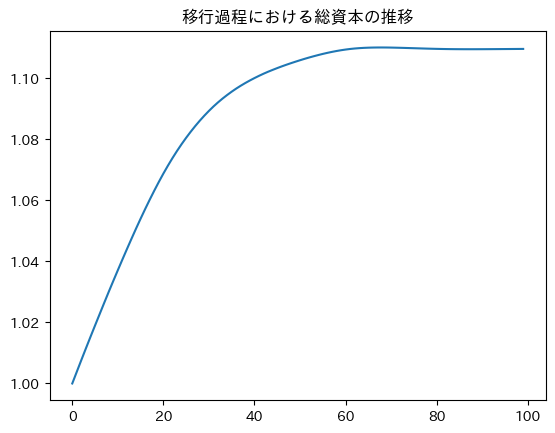

In [68]:
plt.plot(normalized_K_path)
plt.title("移行過程における総資本の推移")
plt.show()

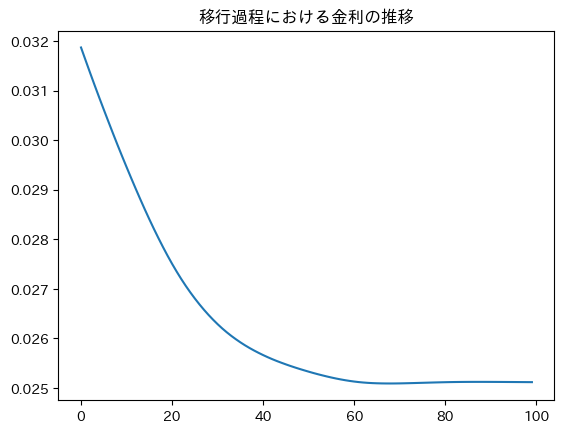

In [66]:
plt.plot(r_path)
plt.title("移行過程における金利の推移")
plt.show()

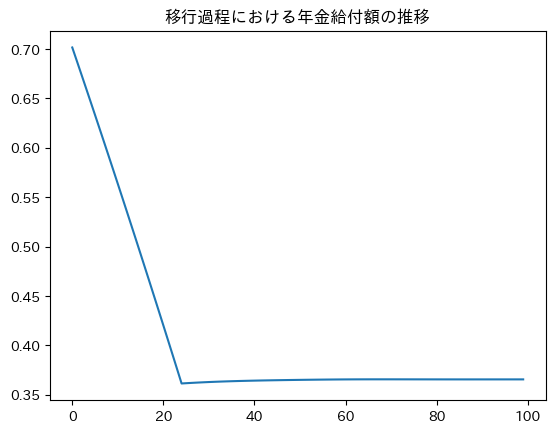

In [65]:
plt.plot(p_path)
plt.title("移行過程における年金給付額の推移")
plt.show()

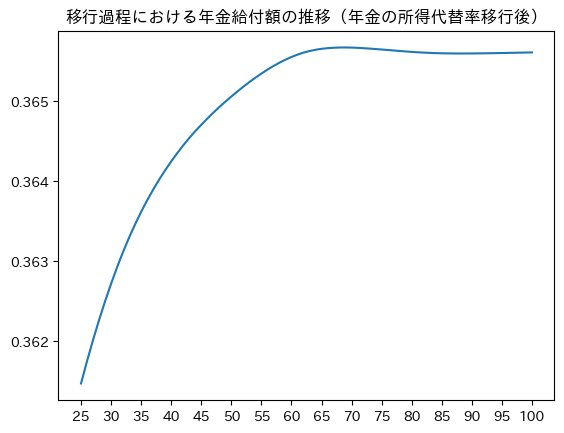

In [71]:
plt.plot(p_path[24:])
plt.title("移行過程における年金給付額の推移（年金の所得代替率移行後）")
plt.xticks(ticks=np.arange(0, 76, 5), labels=np.arange(25, 101, 5))
plt.show()

## 政策変更による厚生効果（図6.5）

In [72]:
cev = olg.cev.calculate_cev(
    tr_setting=tr_setting,
    initial_result=result["initial_result"],
    value_functions=result["value_functions"],
    mu_dists=result["mu_dist_path"],
)

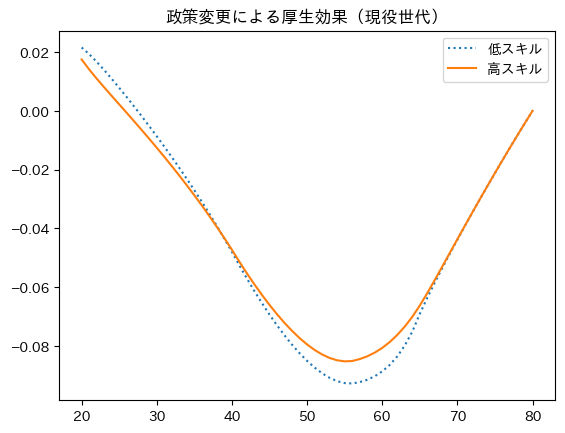

In [ ]:
for i in range(cev.shape[2]):
    if i == 0:
        plt.plot(cev[0,:,i], linestyle='dotted')
    else:
        plt.plot(cev[0,:,i])
plt.title("政策変更による厚生効果（現役世代）")
plt.legend(labels=["低スキル" if i == 0 else "高スキル" for i in range(cev.shape[2])])
plt.xticks(ticks=np.arange(0, 65, 10), labels=np.arange(20, 85, 10))
plt.show()

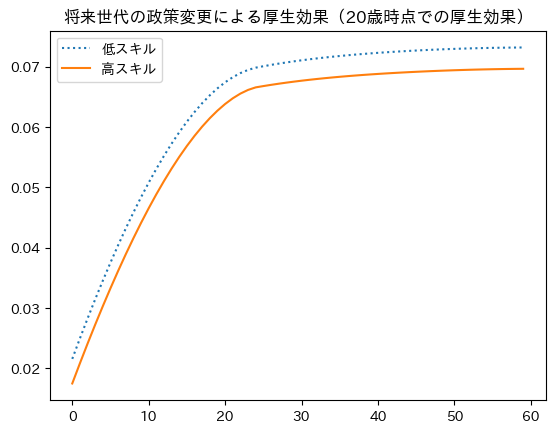

In [99]:
for i in range(cev.shape[2]):
    if i == 0:
        plt.plot(cev[1:61,0,i], linestyle='dotted')
    else:
        plt.plot(cev[1:61,0,i])
plt.title("将来世代の政策変更による厚生効果（20歳時点での厚生効果）")
plt.legend(labels=["低スキル" if i == 0 else "高スキル" for i in range(cev.shape[2])])
plt.show()

## 異なる年金の所得代替率による比較静学

In [100]:
ss_results.keys(), ss_results["ss_psi_00"].__dict__.keys()

(dict_keys(['ss_psi_00', 'ss_psi_05', 'ss_psi_10', 'ss_psi_15', 'ss_psi_20', 'ss_psi_25', 'ss_psi_30', 'ss_psi_35', 'ss_psi_40', 'ss_psi_45', 'ss_psi_50', 'ss_psi_75', 'ss_psi_100']),
 dict_keys(['K', 'r', 'w', 'p', 'tau', 'L', 'value_fun_box', 'policy_fun_box', 'optaprime_index_box', 'mu_dist_box', 'y_list', 'h_dist', 'iterations', 'market_diff', 'errm', 'computation_time', 'hp']))

In [137]:
for path in ss_results_path:
    ss_result = ss_results[path]
    psi = ss_result.hp.psi
    k_l = ss_result.K / ss_result.L
    r = ss_result.r
    w = ss_result.w
    p = getattr(ss_result, "p", None)
    vf = ss_result.value_fun_box[0, 0, 0]
    print(
        f"psi: {psi:.2f}, K/L: {k_l:.5f}, r: {r:.5f}, w: {w:.5f}, p: {p:.5f}, vf: {vf:.5f}"
    )

psi: 0.00, K/L: 10.44276, r: 0.01790, w: 1.53348, p: 0.00000, vf: 7.47136
psi: 0.05, K/L: 10.18136, r: 0.01940, w: 1.51801, p: 0.07590, vf: 7.08760
psi: 0.10, K/L: 9.93468, r: 0.02087, w: 1.50319, p: 0.15032, vf: 6.68561
psi: 0.15, K/L: 9.70233, r: 0.02231, w: 1.48902, p: 0.22335, vf: 6.26667
psi: 0.20, K/L: 9.48312, r: 0.02373, w: 1.47547, p: 0.29509, vf: 5.83127
psi: 0.25, K/L: 9.27493, r: 0.02512, w: 1.46243, p: 0.36561, vf: 5.37973
psi: 0.30, K/L: 9.07629, r: 0.02649, w: 1.44982, p: 0.43495, vf: 4.91184
psi: 0.35, K/L: 8.88490, r: 0.02786, w: 1.43751, p: 0.50313, vf: 4.42711
psi: 0.40, K/L: 8.70317, r: 0.02921, w: 1.42568, p: 0.57027, vf: 3.92719
psi: 0.45, K/L: 8.52947, r: 0.03054, w: 1.41423, p: 0.63640, vf: 3.41158
psi: 0.50, K/L: 8.36039, r: 0.03187, w: 1.40295, p: 0.70147, vf: 2.87885
psi: 0.75, K/L: 7.60669, r: 0.03840, w: 1.35092, p: 1.01319, vf: -0.02803
psi: 1.00, K/L: 6.96583, r: 0.04482, w: 1.30419, p: 1.30419, vf: -3.37566


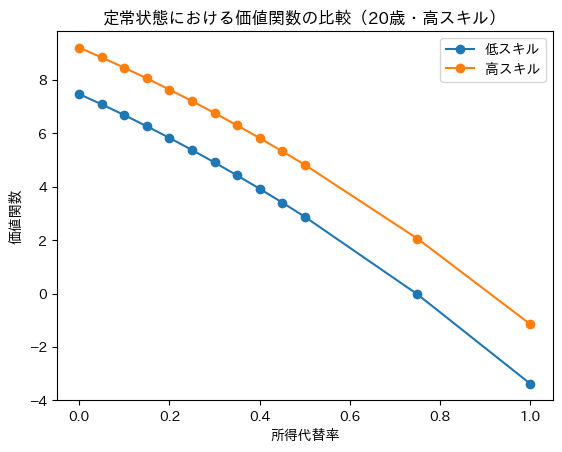

In [135]:
# psiを横軸にvfをプロット
psi_list = []
vf_list = []
for path in ss_results_path:
    ss_result = ss_results[path]
    psi = ss_result.hp.psi
    vf = ss_result.value_fun_box[0, 0, 0]
    psi_list.append(psi)
    vf_list.append(vf)
plt.plot(psi_list, vf_list, marker="o")
psi_list = []
vf_list = []
for path in ss_results_path:
    ss_result = ss_results[path]
    psi = ss_result.hp.psi
    vf = ss_result.value_fun_box[0, 1, 0]
    psi_list.append(psi)
    vf_list.append(vf)
plt.plot(psi_list, vf_list, marker="o")
plt.title("定常状態における価値関数の比較（20歳・高スキル）")
plt.legend(labels=["低スキル", "高スキル"])
plt.xlabel("所得代替率")
plt.ylabel("価値関数")
plt.show()

cev = olg.cev.calculate_cev(
    tr_setting=tr_setting,
    initial_result=result["initial_result"],
    value_functions=result["value_functions"],
    mu_dists=result["mu_dist_path"],
)

In [ ]:
for i in range(cev.shape[2]):
    if i == 0:
        plt.plot(cev[0,:,i], linestyle='dotted')
    else:
        plt.plot(cev[0,:,i])
plt.title("政策変更による厚生効果（現役世代）")
plt.legend(labels=["低スキル" if i == 0 else "高スキル" for i in range(cev.shape[2])])
plt.xticks(ticks=np.arange(0, 65, 10), labels=np.arange(20, 85, 10))
plt.show()

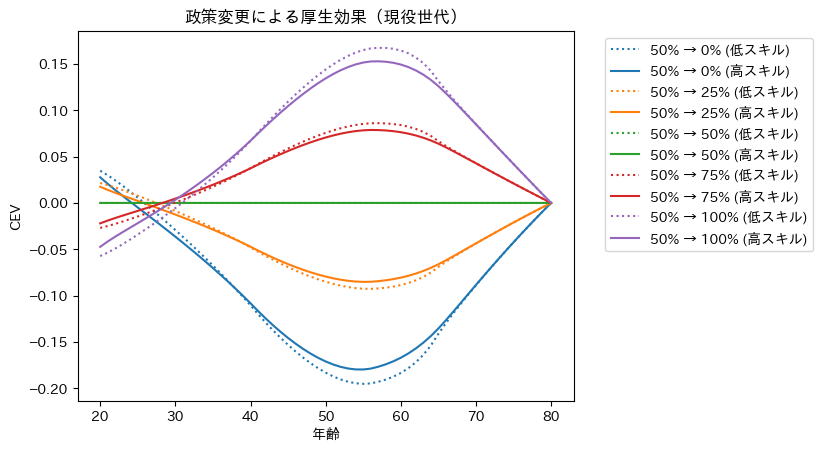

In [148]:
# カラーマップを定義（見やすい色を選択）
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, path in enumerate(transition_results_path):
    result = transition_results[path]
    tr_setting = olg.transition.setting.TransitionSetting(
        NT=100,
        TT=25,
        psi_ini=0.5,
        psi_fin=result["final_result"].hp.psi,
    )
    cev = olg.cev.calculate_cev(
        tr_setting=tr_setting,
        initial_result=result["initial_result"],
        value_functions=result["value_functions"],
        mu_dists=result["mu_dist_path"],
    )

    # 所得代替率のラベルを作成
    psi_ini = 50  # 初期所得代替率
    psi_fin = int(result["final_result"].hp.psi * 100)  # 最終所得代替率
    label_base = f"{psi_ini}% → {psi_fin}%"

    for i in range(cev.shape[2]):
        skill_type = "低スキル" if i == 0 else "高スキル"
        label = f"{label_base} ({skill_type})"

        if i == 0:
            plt.plot(cev[0, :, i], linestyle='dotted',
                    color=colors[idx % len(colors)], label=label)
        else:
            plt.plot(cev[0, :, i], linestyle='-',
                    color=colors[idx % len(colors)], label=label)

plt.title("政策変更による厚生効果（現役世代）")
plt.xlabel("年齢")
plt.ylabel("CEV")
plt.xticks(ticks=np.arange(0, 65, 10), labels=np.arange(20, 85, 10))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

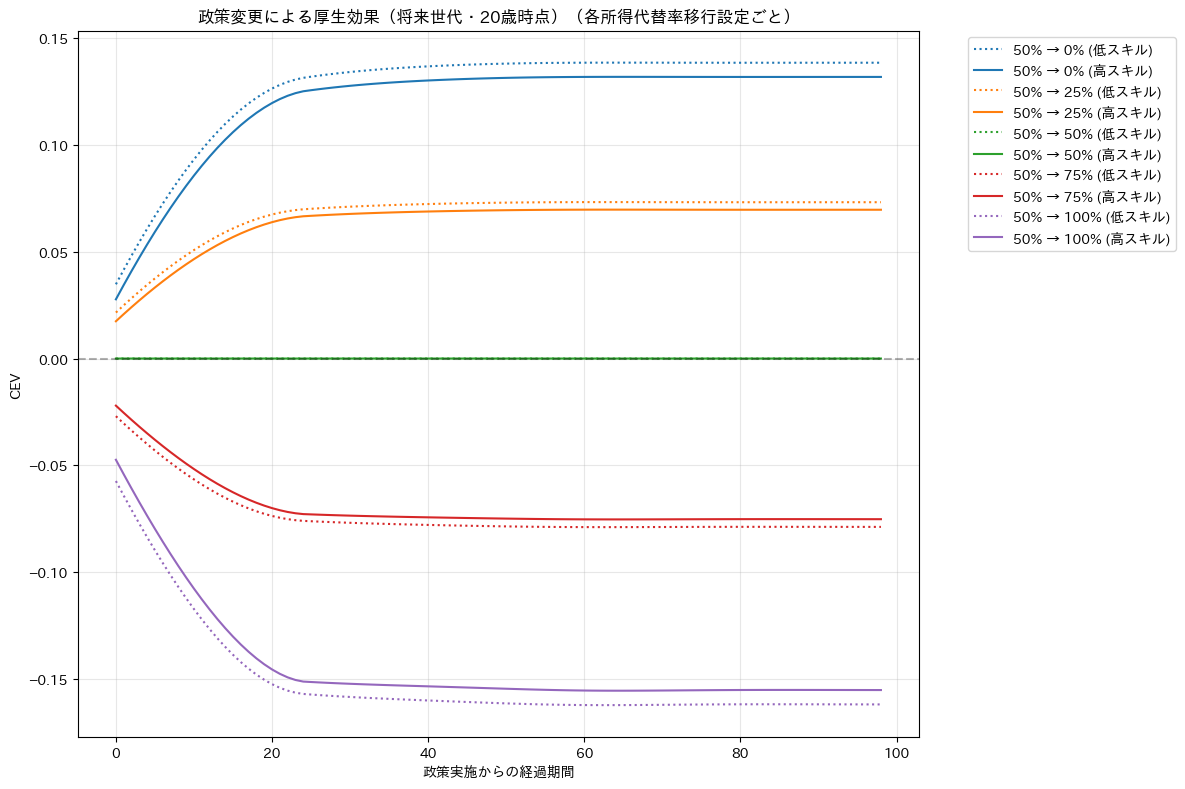

In [150]:
# カラーマップを定義（見やすい色を選択）
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(12, 8))

for idx, path in enumerate(transition_results_path):
    result = transition_results[path]
    tr_setting = olg.transition.setting.TransitionSetting(
        NT=100,
        TT=25,
        psi_ini=0.5,
        psi_fin=result["final_result"].hp.psi,
    )
    cev = olg.cev.calculate_cev(
        tr_setting=tr_setting,
        initial_result=result["initial_result"],
        value_functions=result["value_functions"],
        mu_dists=result["mu_dist_path"],
    )

    # 所得代替率のラベルを作成
    psi_ini = 50  # 初期所得代替率
    psi_fin = int(result["final_result"].hp.psi * 100)  # 最終所得代替率
    label_base = f"{psi_ini}% → {psi_fin}%"

    # 20歳時点での厚生効果（各期間に20歳で生まれる世代）
    # cev[t, 0, i] は t期に20歳（年齢インデックス0）のCEV
    for i in range(cev.shape[2]):
        skill_type = "低スキル" if i == 0 else "高スキル"
        label = f"{label_base} ({skill_type})"

        if i == 0:
            plt.plot(cev[1:, 0, i], linestyle='dotted',
                    color=colors[idx % len(colors)], label=label)
        else:
            plt.plot(cev[1:, 0, i], linestyle='-',
                    color=colors[idx % len(colors)], label=label)

plt.title("政策変更による厚生効果（将来世代・20歳時点）（各所得代替率移行設定ごと）")
plt.xlabel("政策実施からの経過期間")
plt.ylabel("CEV")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)  # ゼロラインを追加
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()